#  <center>Titanic - Machine Learning from Disaster<center>

![](https://img.wallpapersafari.com/desktop/1024/576/85/30/4HQ1V7.jpg)


####  <center>This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works. The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.</center>  

-------------------

Hello!

This competition is considered basic and starting, among other competitions on **Kaggle.**

In this notebook, I will use and study **boosting**, or rather, I will try to use **gradient boosting from the sklearn** library and **gradient boosting from the xgboost** library.
I will try to talk about the differences between these implementations, as well as explain and show which hyperparameters need to be tuned to achieve the best results.

Before building models, I will do **basic analysis**, try to **generate new features**, and also do **basic data preprocessing**.

Okay, time to get started!

First, **import the necessary modules** (I will not import all the modules that will be used in the notebook at once. Instead, I will import them separately, depending on the tasks of the block.)

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
output_example = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Okay, let's do some data manipulation right away:

1. I will **remove the PassengerId** feature, since it does not carry any information other than the person's id


2. I **convert all columns to lowercase** (There is no serious need for this, but it’s more convenient for me to write feature this way, for example, SibSP has 2 capital letters in the name, it would be better if there are no capital letters at all)


3. I will **convert the Sex classes into binary** 1 and 0 (In any case, this will have to be done, but it is more convenient to do this in advance)

In [4]:
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

In [5]:
train.columns = train.columns.map(lambda x: x.lower())
test.columns = test.columns.map(lambda x: x.lower())

First, let's make sure that Sex contains 2 classes: **male** and  **female**

In [6]:
print('Number of classes:', train['sex'].nunique())

Number of classes: 2


In [7]:
train['sex'] = np.where(train['sex']=='male', 1, 0)
test['sex'] = np.where(test['sex']=='male', 1, 0)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    int64  
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


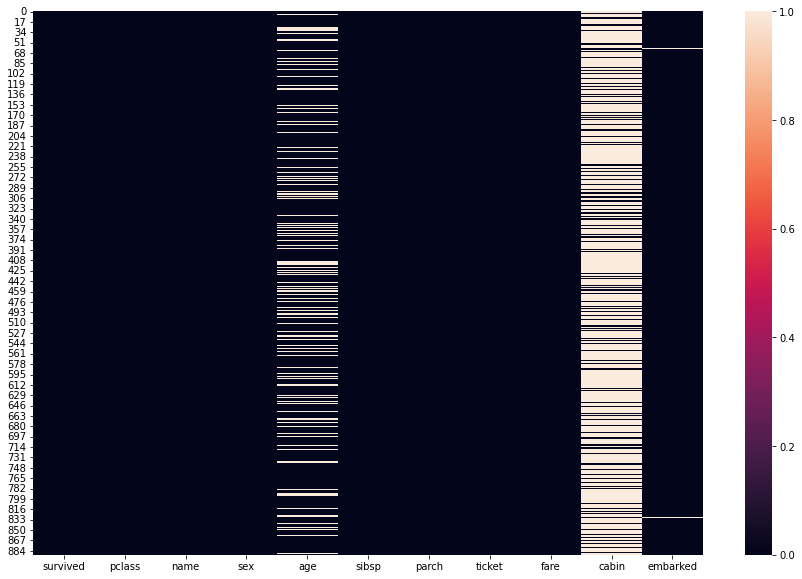

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(train.isnull());

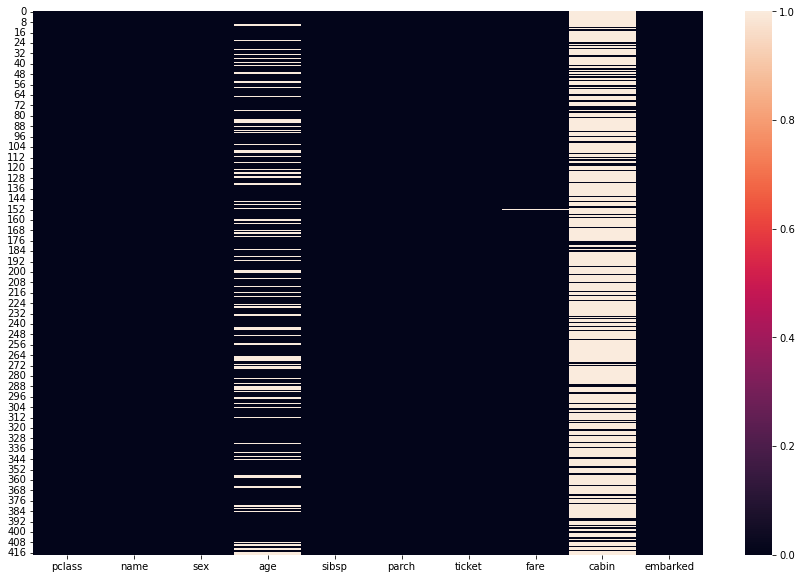

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(test.isnull());

We can see that the data has many missing values.

1. Training and test data have many missing values in the **Age**

2. Training and test data has a lot of missing values in the **Cabin**

3. The training data has few missing values in the **Embarked**

4. Test data has one missing value in the **Fare **

Well, we will **fill in the missing values gradually**, by analyzing the variables we will better understand how to fill in the missing values correctly.

**Let's start analyzing features**

#  <center>| EDA & Feature Engineering & Missing Values |</center>

![](https://i.ytimg.com/vi/Xk0TTY0kZ4A/hqdefault.jpg?sqp=-oaymwEjCPYBEIoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLB4PPIiRY9YGVA93j_JQBIUQCmF-g)  

### Survived

Let's start with the target feature **Survived**

In [11]:
print('Target distribution','-'*20, sep='\n')
print('Survived: {0} %'.format(train['survived'].value_counts(normalize=True).round(2).values[1]))
print('Not survived: {0} %'.format(train['survived'].value_counts(normalize=True).round(2).values[0]))
print('-'*20)

Target distribution
--------------------
Survived: 0.38 %
Not survived: 0.62 %
--------------------


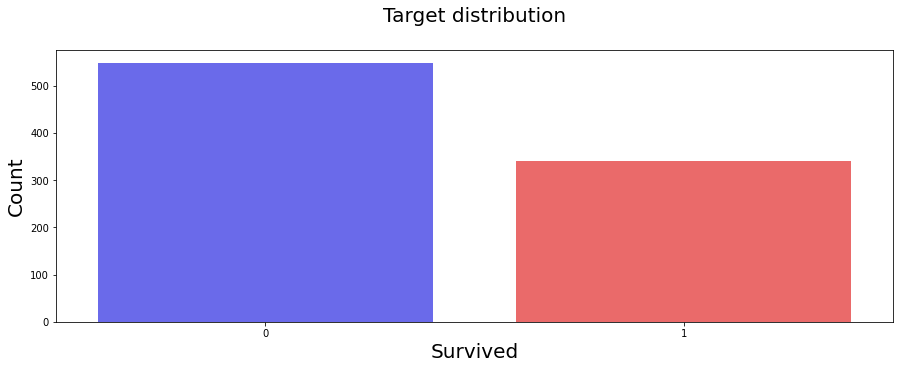

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(data=train, x='survived', palette='seismic')
plt.title('Target distribution\n', fontsize=20)
plt.xlabel('Survived', fontsize=20)
plt.ylabel('Count', fontsize=20);

We see a **slight imbalance** in the distribution of target trait classes.

Less survivors in training data than fatalities

## General Feature Analysis

First, let's take a look at **pairplot** and take a quick look at the **relationships between features.**

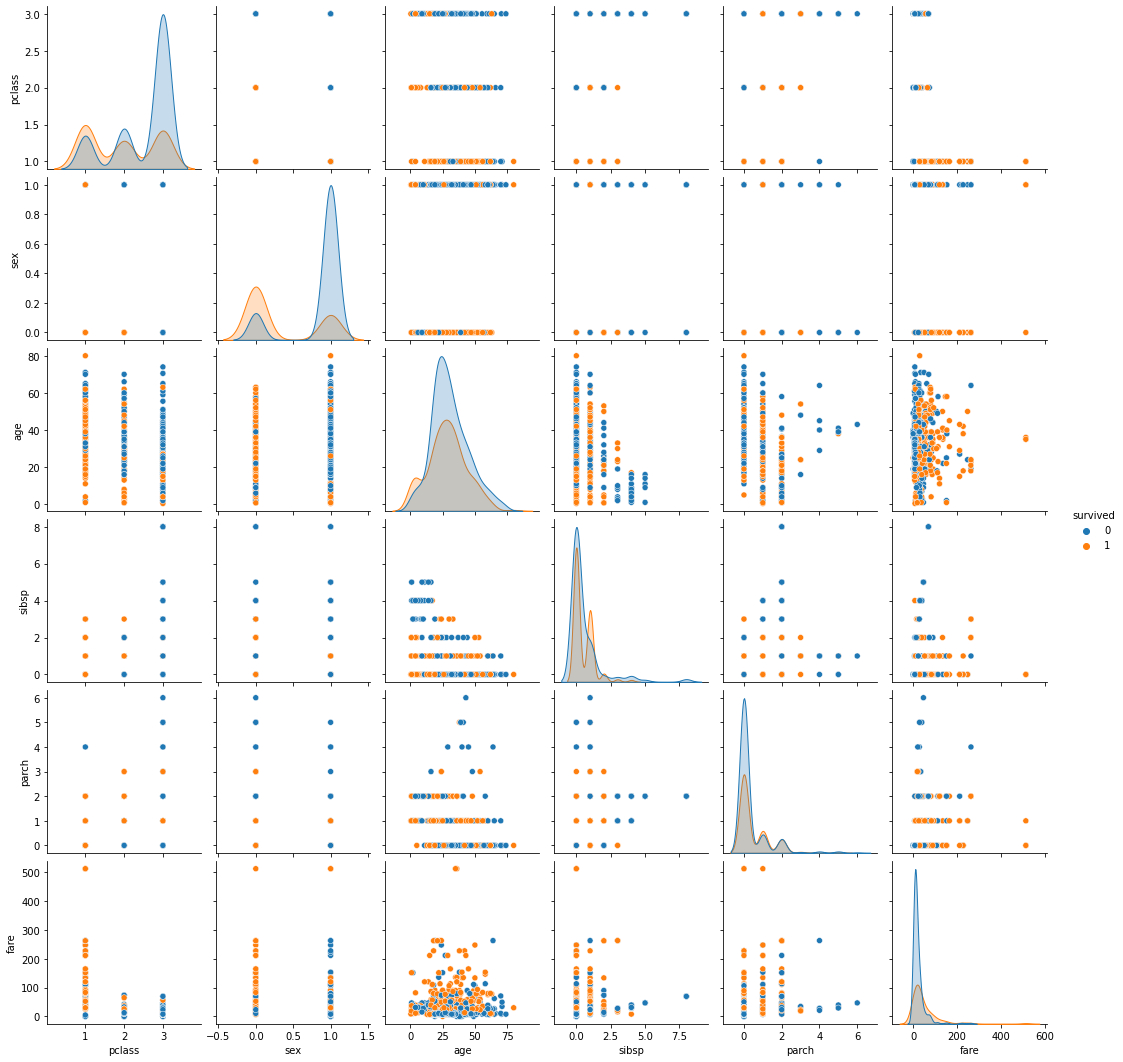

In [13]:
sns.pairplot(data=train, hue='survived');

With a quick paiplot analysis, the following conclusions can be drawn:


1. There are significant features, the values of which directly affect the distribution of the target feature


2. Most often **people survived in pclass : 1 and sex : 0**, most likely these are the 2 most important features


3. There is a **relationship between fare and the target feature**: the higher the value of fare, the more often people survived

Let's take a **look at the text statistics of features**

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
sex,891.0,0.647587,0.477990,0.00,0.0000,1.0000,1.0,1.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


It can be noted that most of the **features in the data are categorical**, with the predominance of one of the classes

For example **sibsp** and **parch** have the most **values >1**

**Fare does not have a normal distribution**, because **75% of all values do not go beyond 31, but have std 49 and max 512**

**pclass : 3** is much more common than the other values since it has **50% and 75% == 3**

These conclusions could be drawn by looking at pairplot, but sometimes it is very **useful to look at accurate descriptive statistics.**

---------------------

Okay, let's get into detailed feature analysis, starting with **sibsp** and **parch** features

## The most important thing in life will always be Family (SibSp & Parch)

![](https://museumofmemes.org/wp-content/uploads/2021/07/fast-and-furious-dom-family-meme-original.jpg)  

As Dominic Toretto bequeathed, **family is the most important thing in life**, so let's start with it)

First, let's take a look at which feature classes are responsible for what.

#### sibsp: 

1. **Sibling = brother, sister, stepbrother, stepsister**
2. **Spouse = husband, wife** (mistresses and fiancés were ignored)

#### parch: 
1. **Parent = mother, father**
2. **Child = daughter, son, stepdaughter, stepson**

Some children travelled only with a nanny, therefore parch=0 for them.

In [15]:
pd.crosstab(train['parch'], train['sibsp'])

sibsp,0,1,2,3,4,5,8
parch,,,,,,,
0,537,123,16,2,0,0,0
1,38,57,7,7,9,0,0
2,29,19,4,7,9,5,7
3,1,3,1,0,0,0,0
4,1,3,0,0,0,0,0
5,2,3,0,0,0,0,0
6,0,1,0,0,0,0,0


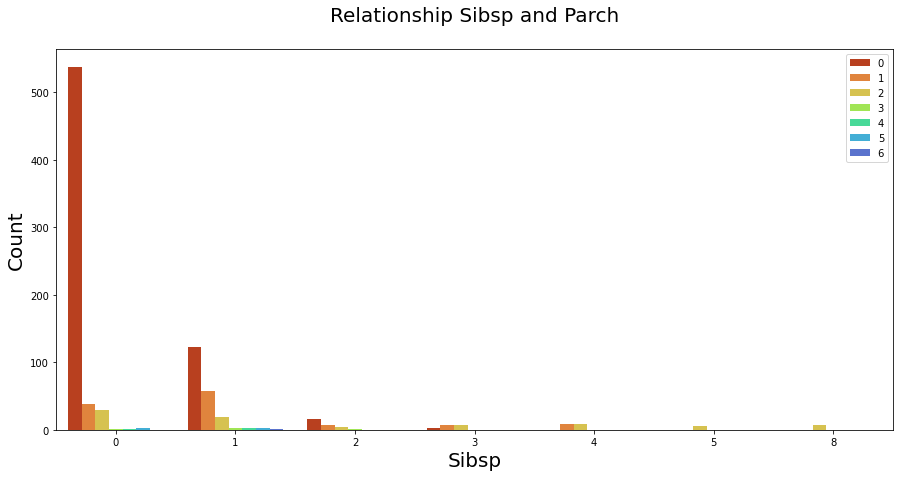

In [16]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='sibsp', hue='parch', palette='turbo_r')
plt.legend(loc='upper right')
plt.title('Relationship Sibsp and Parch\n', fontsize=20)
plt.xlabel('Sibsp', fontsize=20)
plt.ylabel('Count', fontsize=20);

It can be seen that **most often there are people who do not have any relatives on board**

I don't quite understand yet how **sibsp** and **parch** are related, but there is definitely a **relationship**

Let's take a look at a few examples where the whole family got on the Titanic.

I will assume that people with the same **surname** and **similar meanings of sibsp and parch will be one family**

To do this, I will **create a separate column in the data, which will select only the last name from name**

In [17]:
train['surname'] = train['name'].apply(lambda x: x[:x.index(',')])

In [18]:
train['surname'].value_counts()

Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: surname, Length: 667, dtype: int64

In [19]:
train[train['surname']=='Andersson']

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,surname
13,0,3,"Andersson, Mr. Anders Johan",1,39.0,1,5,347082,31.2750,NaN,S,Andersson
68,1,3,"Andersson, Miss. Erna Alexandra",0,17.0,4,2,3101281,7.9250,NaN,S,Andersson
119,0,3,"Andersson, Miss. Ellis Anna Maria",0,2.0,4,2,347082,31.2750,NaN,S,Andersson
146,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",1,27.0,0,0,350043,7.7958,NaN,S,Andersson
541,0,3,"Andersson, Miss. Ingeborg Constanzia",0,9.0,4,2,347082,31.2750,NaN,S,Andersson
542,0,3,"Andersson, Miss. Sigrid Elisabeth",0,11.0,4,2,347082,31.2750,NaN,S,Andersson
610,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",0,39.0,1,5,347082,31.2750,NaN,S,Andersson
813,0,3,"Andersson, Miss. Ebba Iris Alfrida",0,6.0,4,2,347082,31.2750,NaN,S,Andersson
850,0,3,"Andersson, Master. Sigvard Harald Elias",1,4.0,4,2,347082,31.2750,NaN,S,Andersson


In [20]:
train[train['surname']=='Carter']

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,surname
249,0,2,"Carter, Rev. Ernest Courtenay",1,54.0,1,0,244252,26.0,NaN,S,Carter
390,1,1,"Carter, Mr. William Ernest",1,36.0,1,2,113760,120.0,B96 B98,S,Carter
435,1,1,"Carter, Miss. Lucile Polk",0,14.0,1,2,113760,120.0,B96 B98,S,Carter
763,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",0,36.0,1,2,113760,120.0,B96 B98,S,Carter
802,1,1,"Carter, Master. William Thornton II",1,11.0,1,2,113760,120.0,B96 B98,S,Carter
854,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",0,44.0,1,0,244252,26.0,NaN,S,Carter


OK, here are some interesting things to note:

1. **sibsp** and **parch may differ** for different family members, but the **sum of sibsp and parch is the same**

2. Families have the **same tickets**

3. Families have the **same ticket price**

4. Families have the **same cabins**

There are several questions with the last points, it may well be that one of the family members will live in a separate cabin and will have different fare and ticket values, so this is not the most obvious sign for me.

The situation with the fare sign is also not entirely clear: **fare:120 can mean that a given amount was paid for each family member or the total amount for the whole family is 120**

We will deal with the cost later, but with **1. everything is obvious, we will create a new feature responsible for the size of the family** (Since the union of these features does not include the person for whom this feature was created, we will add +1)

In [21]:
train['family_size'] = train['sibsp']+train['parch']+1
test['family_size'] = test['sibsp']+test['parch']+1

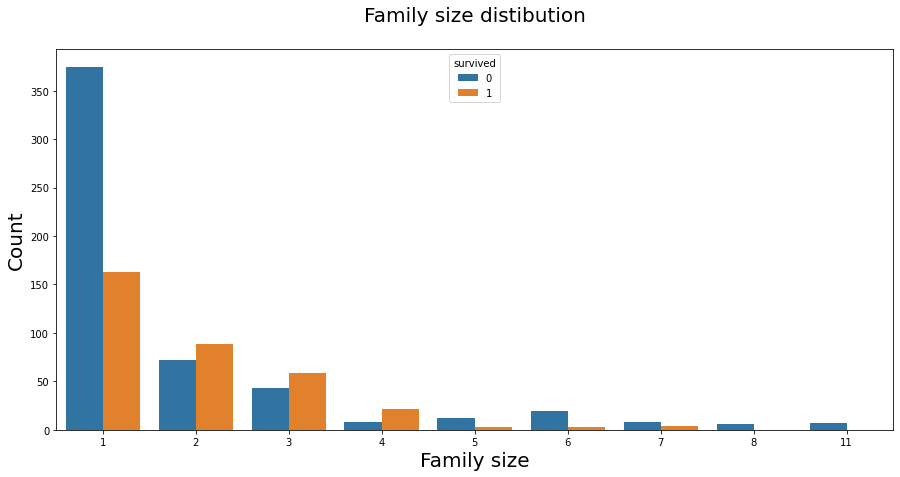

In [22]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='family_size', hue='survived');
plt.title('Family size distibution\n', fontsize=20)
plt.xlabel('Family size', fontsize=20)
plt.ylabel('Count', fontsize=20);

Great, now I propose to deal with the **fare** feature and **similar feature that indicate the value of the cabin**

---------------

## Money rules the world... (Pclass & Fare)

![](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/save-money-on-commute-1536314738.jpg?crop=0.6678445229681979xw:1xh;center,top&resize=320:*)  

Let's start with the Pclass feature

#### pclass: A proxy for socio-economic status (SES)


1. **1st = Upper**
2. **2nd = Middle**
3. **3rd = Lower**

In [23]:
print('Pclass distribution','-'*20, sep='\n')
print('class 3: {0} %'.format(train['pclass'].value_counts(normalize=True).round(2).values[0]))
print('class 2: {0} %'.format(train['pclass'].value_counts(normalize=True).round(2).values[1]))
print('class 1: {0} %'.format(train['pclass'].value_counts(normalize=True).round(2).values[2]))
print('-'*20)

Pclass distribution
--------------------
class 3: 0.55 %
class 2: 0.24 %
class 1: 0.21 %
--------------------


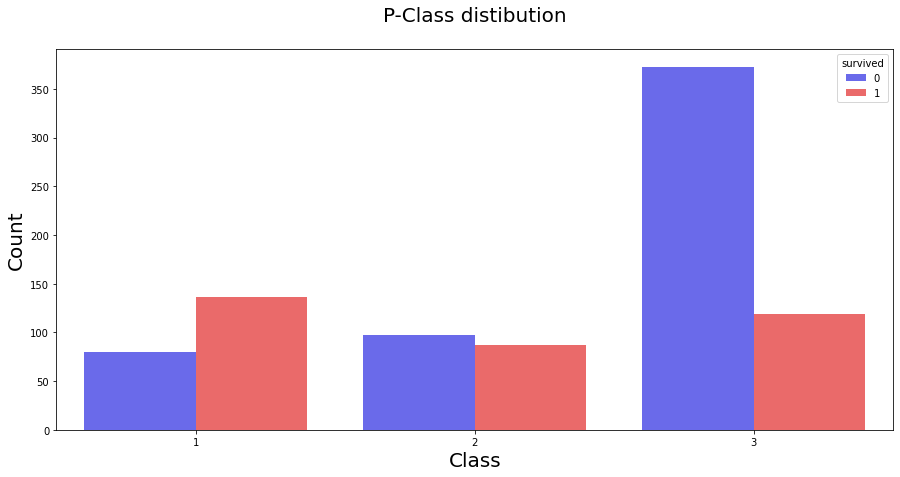

In [24]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='pclass', hue='survived', palette='seismic')
plt.title('P-Class distibution\n', fontsize=20)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Count', fontsize=20);

It can be seen that **pclass:3 has the highest mortality among humans.**

It is logical to assume that **pclass will be closely related to fare**, let's take a look at this feature

In [25]:
train['fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

For convenience of visualization, we use **np.log(train['fare'])**

There is no direct need for this, but the **graph becomes more beautiful**

In the future, I **will not do the transformation of the feature into the log form**, since we will not use linear models, and for decision trees, the log transformation does not make any sense

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


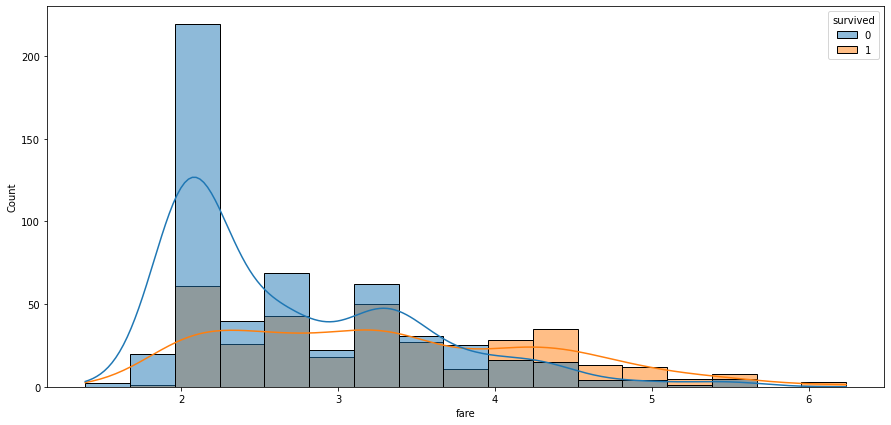

In [26]:
plt.figure(figsize=(15,7))
sns.histplot(data=train, x=np.log(train['fare']), kde=True, hue='survived');

Indeed, we observe a situation where the **higher the cost of a ticket, the higher the chance of people surviving**

Let's remember that in the test data we had **one missing value for the fare** feature, we **need to fill it**

### Missing Values: Fare

In [27]:
test.iloc[152, :]

pclass                          3
name           Storey, Mr. Thomas
sex                             1
age                          60.5
sibsp                           0
parch                           0
ticket                       3701
fare                          NaN
cabin                         NaN
embarked                        S
family_size                     1
Name: 152, dtype: object

I propose to fill in this missing value by the **average fare for the pclass of this person**

In [28]:
test['fare'].fillna(test[test['pclass']==3]['fare'].mean(), inplace=True)

Let's **create a new feature that is responsible for the family cost of the ticket.**

Here it is necessary to decide what logic we will adhere to:

1. **fare value for the total cost of the ticket**
2. **fare value per ticket price per person**

In general, I'm not entirely sure that this feature is necessary and can make important changes to the result of the model, I will check it and make a comment about how the feature affects the result

In the meantime, we **decide to stick to option 2** and **divide the cost by the size of the family**

In [29]:
train['family_fare'] = train['fare']/train['family_size']
test['family_fare'] = test['fare']/test['family_size']

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


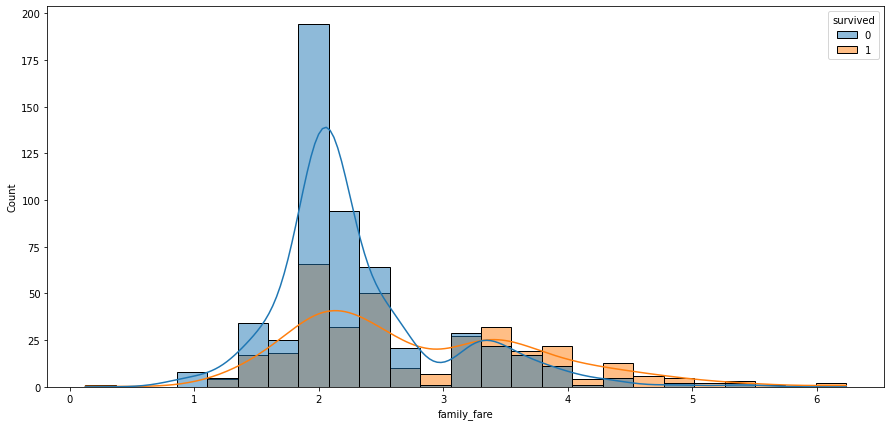

In [30]:
plt.figure(figsize=(15,7))
sns.histplot(data=train, x=np.log(train['family_fare']), kde=True, hue='survived');

Ok, let's take a look at the **relationship between fare and pclass**

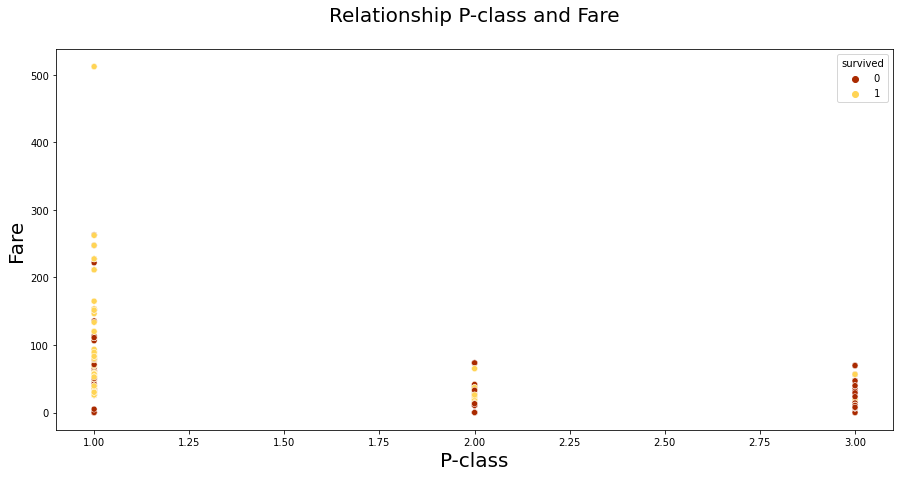

In [31]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=train, x='pclass', y='fare', hue='survived', palette='afmhot')
plt.title('Relationship P-class and Fare\n', fontsize=20)
plt.xlabel('P-class', fontsize=20)
plt.ylabel('Fare', fontsize=20);

As we assumed, for **P-class:1 the average fare is higher**

Great, let's start **analyzing the age** of the passengers on the Titanic.

----------------

## Being young is great! (Age)

![](https://vpodobay.co/wp-content/uploads/2021/06/TSikave.jpg)  

In [32]:
train['age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

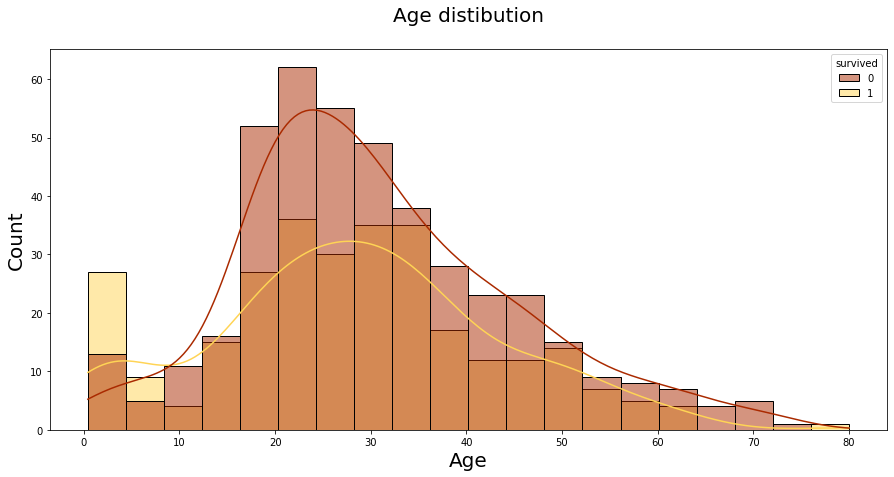

In [33]:
plt.figure(figsize=(15,7))
sns.histplot(data=train, hue='survived', x='age', kde=True, palette='afmhot');
plt.title('Age distibution\n', fontsize=20)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Count', fontsize=20);

Here are the conclusions that can be drawn:

1. **Children were the most likely to survive**


2. **Old people most often died**


3. **For people ~35 years old and 50 years old, approximately the same distribution of the target feature**


I propose to introduce a feature that is responsible for the **age group of a person**

But before that, let's **fill in the missing values in the training and test data**

### Missing Values : Age

Here I want to use **KNNImputer() to fill in missing values.**

Imputation for completing missing values using **k-Nearest Neighbors.**

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

default **hyperparameter n_neighbor = 5**

I won't set hyperparameters for KNNImputer(), I think it works well with default settings

For more information about KNNImputer, you can refer to the sklearn manual

**https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html**

In [34]:
from sklearn.impute import KNNImputer

In [35]:
imputer = KNNImputer()

**Don't forget that the train data has a target feature**

In order for it not to be used when recovering missing values, we **will not use it when filling**

In [36]:
train_fill = train.select_dtypes(exclude='object').drop(['survived'], axis=1)
test_fill = test.select_dtypes(exclude='object')

In [37]:
train_fill = pd.DataFrame(imputer.fit_transform(train_fill), columns=train_fill.columns)

test_fill = pd.DataFrame(imputer.transform(test_fill), columns=test_fill.columns)

In [38]:
train['age'] = train_fill['age']
test['age'] = test_fill['age']

Great, now let's start **generating a new feature that will be responsible for the age group of a person**

For convenience, we divide into **5 different groups**:

1. **Up to 10 years - 0**

2. **Under 30 - 1**

3. **Under 45 - 2**

4. **Under 60 - 3**

5. **Over 60 - 4**

In order not to get confused with writing a lambda function, let's write a separate function

In [39]:
def age_groups(age):
    if age<15:
        return 0
    elif age<31:
        return 1
    elif age<45:
        return 2
    elif age<61:
        return 3
    else:
        return 4

In [40]:
train['age_type'] = train['age'].apply(age_groups)
test['age_type'] = test['age'].apply(age_groups)

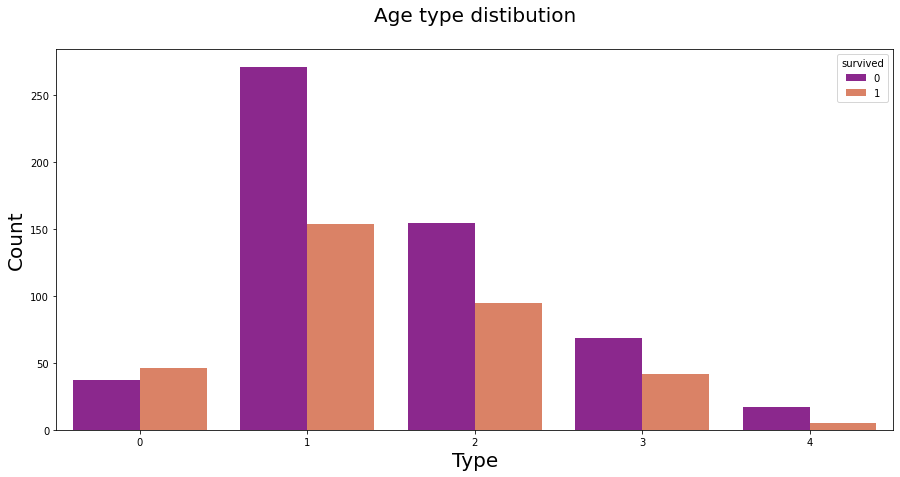

In [41]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='age_type', hue='survived', palette='plasma');
plt.title('Age type distibution\n', fontsize=20)
plt.xlabel('Type', fontsize=20)
plt.ylabel('Count', fontsize=20);

Great, now let's take a **look at the Sex.**

## Sex and Resilient Women (Sex)

![](https://i.pinimg.com/236x/9f/68/7a/9f687a5419418dd3ad576e6d2fa0a0cc--crossfit-gifts-crossfit-women.jpg)  

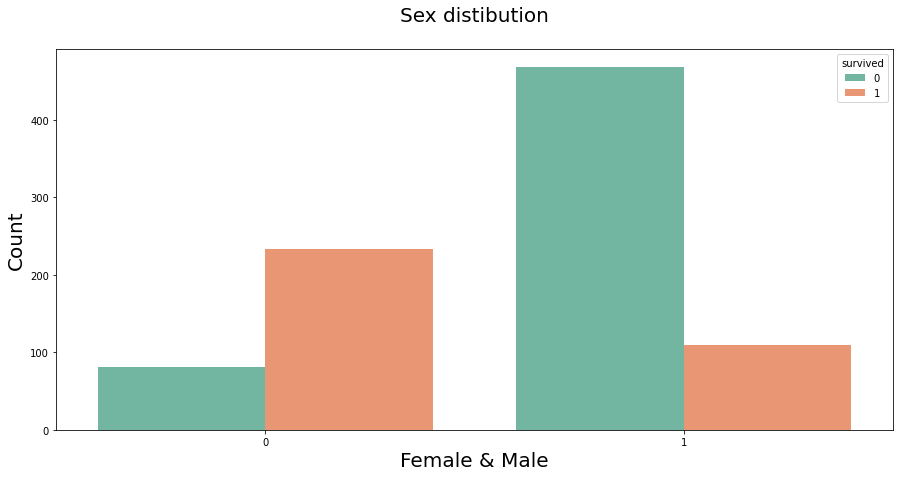

In [42]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='sex', hue='survived', palette='Set2')
plt.title('Sex distibution\n', fontsize=20)
plt.xlabel('Female & Male', fontsize=20)
plt.ylabel('Count', fontsize=20);

As we observed in the baseline analysis, **women did indeed survive more often.**

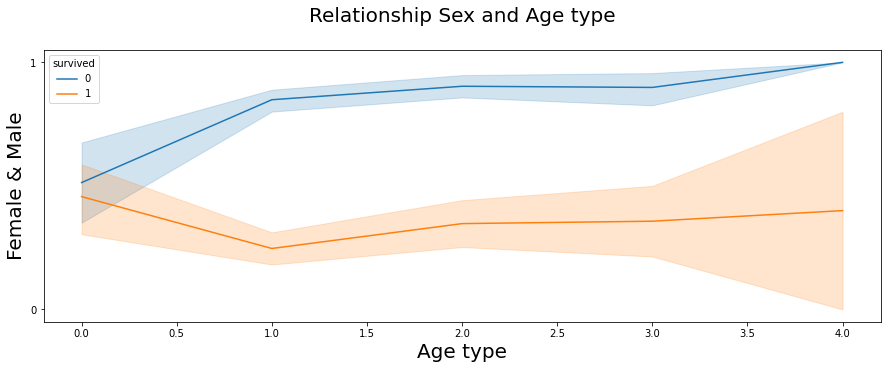

In [43]:
plt.figure(figsize=(15,5))
sns.lineplot(data=train, x='age_type', y='sex', hue='survived')
plt.title('Relationship Sex and Age type\n', fontsize=20)
plt.xlabel('Age type', fontsize=20)
plt.ylabel('Female & Male', fontsize=20)
plt.yticks([0,1]);

Probably not the most convenient construction of histplot, but it seems to me that the main dependencies are clearly visible on it:

1. **Women who are  in the 1 and 2 group always survive more than men.**

2. **People who fall into the 1 and 2 groups always survive more often**

-----------------

Ok, let's move on to the **last part of the feature analysis**, in which I will **study Embarked and Cabin**

## Embarked , get in your Cabins! (Embarked & Cabin & Ticket)

![](https://static.tildacdn.com/tild3364-3539-4630-b364-626263326561/capitan_icon.png)  

#### Embarked

Port of Embarkation

1. **C = Cherbourg**
2. **Q = Queenstown**
3. **S = Southampton**

In [44]:
train['embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: embarked, dtype: float64

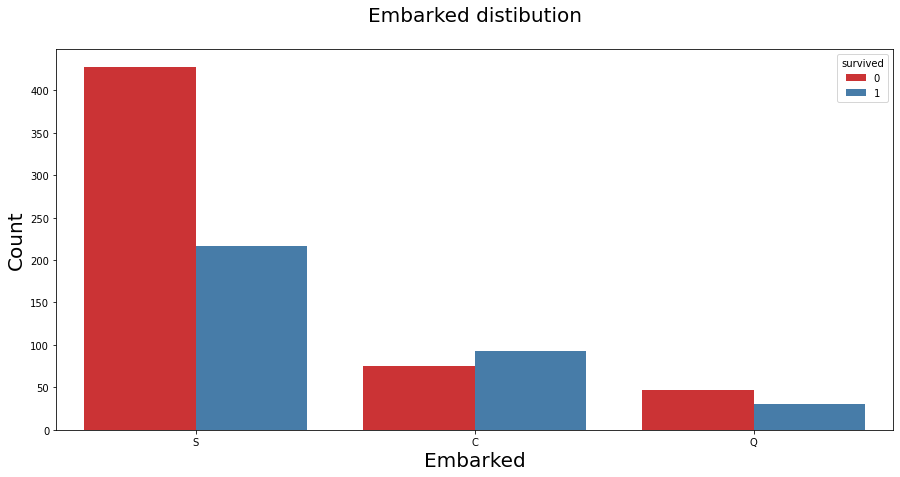

In [45]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='embarked', hue='survived', palette='Set1')
plt.title('Embarked distibution\n', fontsize=20)
plt.xlabel('Embarked', fontsize=20)
plt.ylabel('Count', fontsize=20);

**Most people landed at Southampton**, but people from **Cherbourg survived more than others.** Perhaps this is due to the fact that **people from Cherbourg took safer places when landing**

Let's make sure this

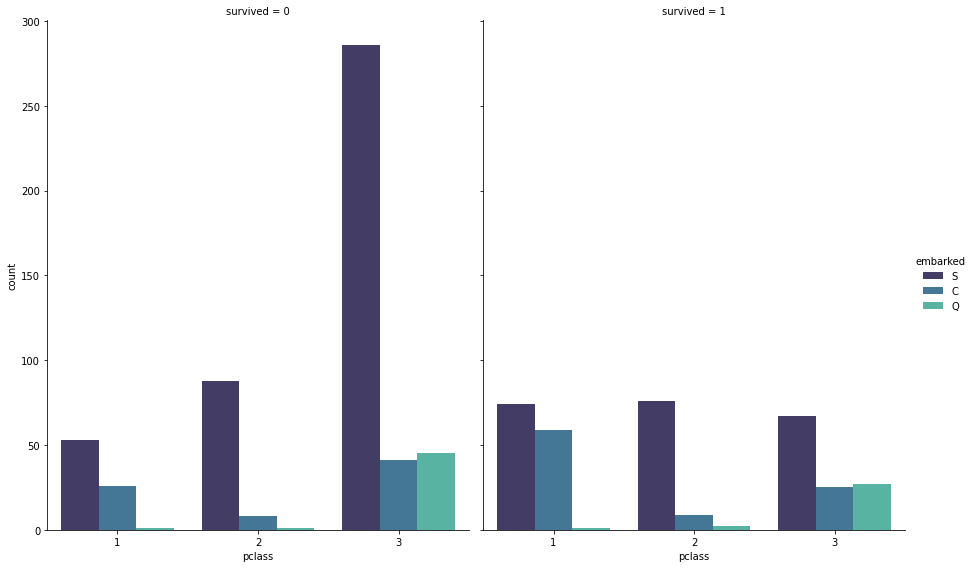

In [46]:
sns.catplot(data=train, x="pclass", hue="embarked", col="survived", kind="count", height=8, aspect=0.8, palette='mako');

Indeed, people from **Southampton and Queenstown mostly took places in pclass:3**

From **Cherbourg there is no such difference anymore between the choice of classes.** As elsewhere, **pclass:3 dominates**, but the **sum of places in pclass:1 and 2 is approximately equal to the number of places in pclass:3**


**However, a less consistent pattern emerges for the distribution of survivors.**

In my opinion, **any hypotheses and analyzes are not very useful here,** because the **sample size is quite small**, I do not think that it is possible to judge any pattern with a **sample of ~50 for each category**

------------------------------

Let's **now tackle the missing values** in the training data

### Missing Values: Embarked

In [47]:
train.iloc[[829,61], :]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,surname,family_size,family_fare,age_type
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,Stone,1,80.0,4
61,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,Icard,1,80.0,2


Hmm, it's interesting that both of these passes are interconnected with each other, because they have the **same tickets.**

I will assume they are both from Southampton, I have 2 reasons for that

1. **most people from Southampton**

2. **name Stone, Mrs. George Nelson is more like English**

In [48]:
train['embarked'].fillna('S', inplace=True)

Before that, I did not pay attention that people may not be related in order to ride together, so we can **generate a new feature**. **He will be responsible for the presence of satellites in humans.**

In [49]:
check_ticket_train = dict.fromkeys(train['ticket'].unique().tolist())
for key in check_ticket_train:
    check_ticket_train[key] = -1
    
for ticket in train['ticket'].values.tolist():
    check_ticket_train[ticket] += 1
    
check_ticket_test = dict.fromkeys(test['ticket'].unique().tolist())
for key in check_ticket_test:
    check_ticket_test[key] = 0
    
for ticket in test['ticket'].values.tolist():
    check_ticket_test[ticket] += 1    

In [50]:
def ticket_count_train(ticket):
    return check_ticket_train[ticket]

def ticket_count_test(ticket):
    return check_ticket_test[ticket]

In [51]:
train['count_companions'] = train['ticket'].apply(ticket_count_train)
test['count_companions'] = test['ticket'].apply(ticket_count_test)

This is not the most successful implementation of the function, but I didn’t figure out how to do it otherwise :)

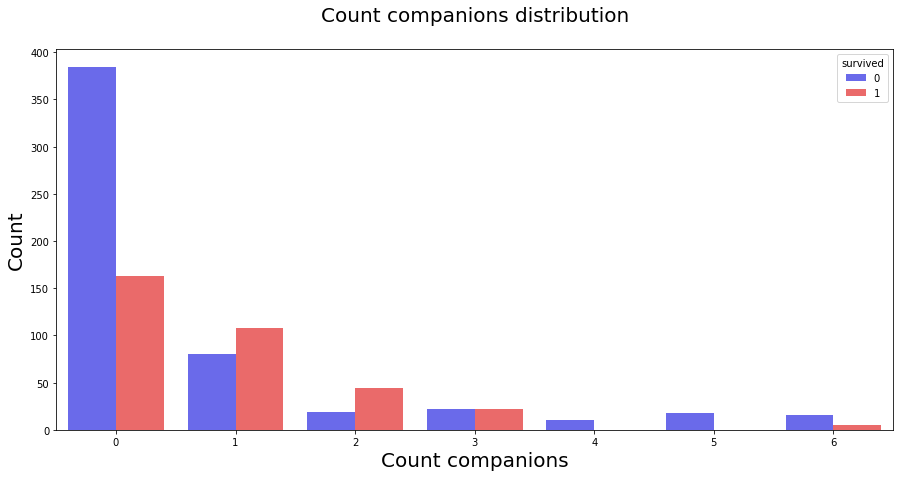

In [52]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='count_companions', hue='survived', palette='seismic')
plt.title('Count companions distribution\n', fontsize=20)
plt.xlabel('Count companions', fontsize=20)
plt.ylabel('Count', fontsize=20);

Ok, now let's deal with the **cabin**

Initially, I thought that it can simply be excluded and it does not carry any information, but after looking closely at it, I noticed that the **cabin types depend on the letter**, and we will **try to generate a new feature** using them

In [53]:
train['cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

### Missing Values: Cabin

There are a lot of missing values in cabin, so **fill them in with N (None)**

In [54]:
train['cabin'].fillna('N', inplace=True)
test['cabin'].fillna('N', inplace=True)

In [55]:
train['cabin_type'] = train['cabin'].apply(lambda x: x[0])
test['cabin_type'] = test['cabin'].apply(lambda x: x[0])

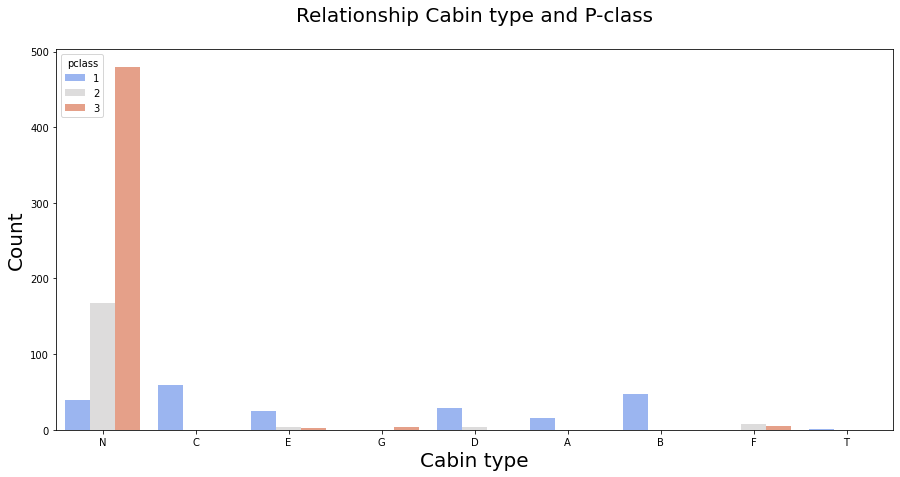

In [56]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='cabin_type', hue='pclass', palette='coolwarm')
plt.title('Relationship Cabin type and P-class\n', fontsize=20)
plt.xlabel('Cabin type', fontsize=20)
plt.ylabel('Count', fontsize=20);

It can be noted that certain **cabin_types** refer to a specific pclass, e.g. **A,B,C only refer to pclass:1**

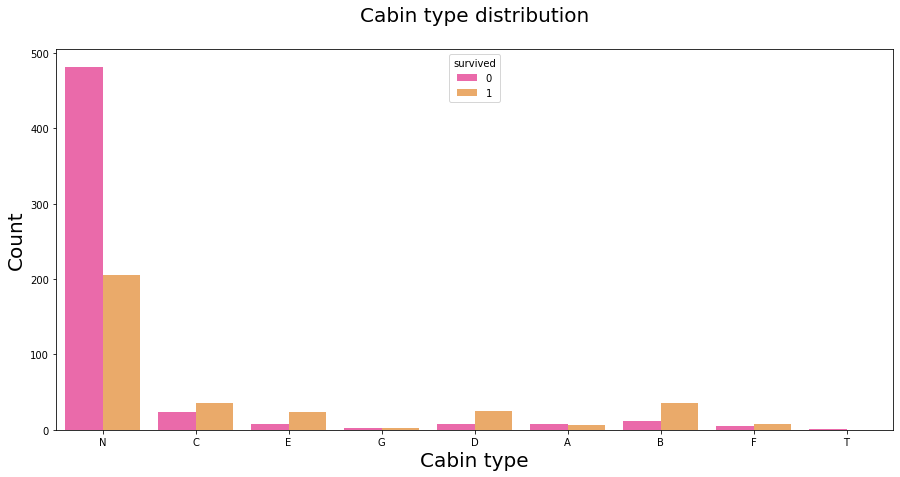

In [57]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='cabin_type', hue='survived', palette='spring')
plt.title('Cabin type distribution\n', fontsize=20)
plt.xlabel('Cabin type', fontsize=20)
plt.ylabel('Count', fontsize=20);

For each **cabine_type** class, we **have very few examples**, in this case, I would **combine some similar cabine_type classes**.

In [58]:
train['cabin_type'].replace(['N'], 0, inplace=True)
train['cabin_type'].replace(['A','B','C'], 1, inplace=True)
train['cabin_type'].replace(['D','E'], 2, inplace=True)
train['cabin_type'].replace(['F','G','T'], 3, inplace=True)

test['cabin_type'].replace(['N'], 0, inplace=True)
test['cabin_type'].replace(['A','B','C'], 1, inplace=True)
test['cabin_type'].replace(['D','E'], 2, inplace=True)
test['cabin_type'].replace(['F','G','T'], 3, inplace=True)

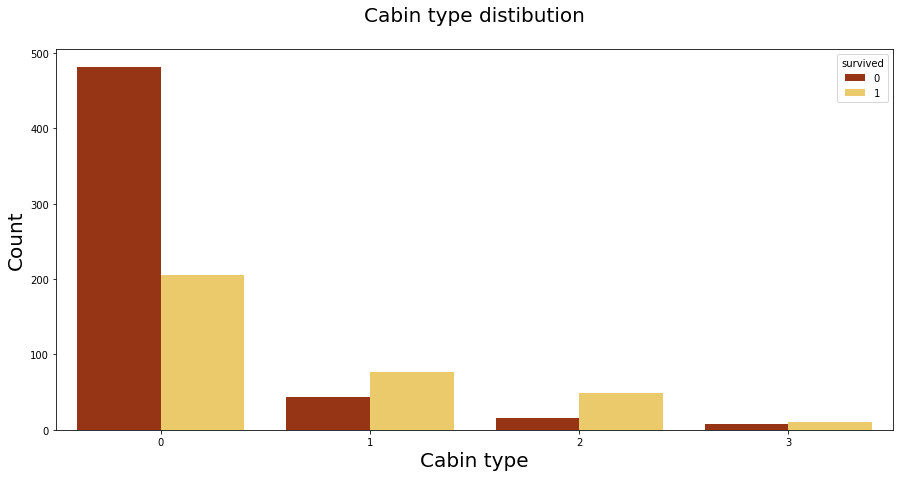

In [59]:
plt.figure(figsize=(15,7))
sns.countplot(data=train, x='cabin_type', hue='survived', palette='afmhot')
plt.title('Cabin type distibution\n', fontsize=20)
plt.xlabel('Cabin type', fontsize=20)
plt.ylabel('Count', fontsize=20);

Great, we are **done with the feature analysis**, **generated some new features**, and **filled in all the missing values.**

In the end, I propose to **look at the correlation matrix** and see which features are of the greatest importance for the target feature.

## Correlation matrix

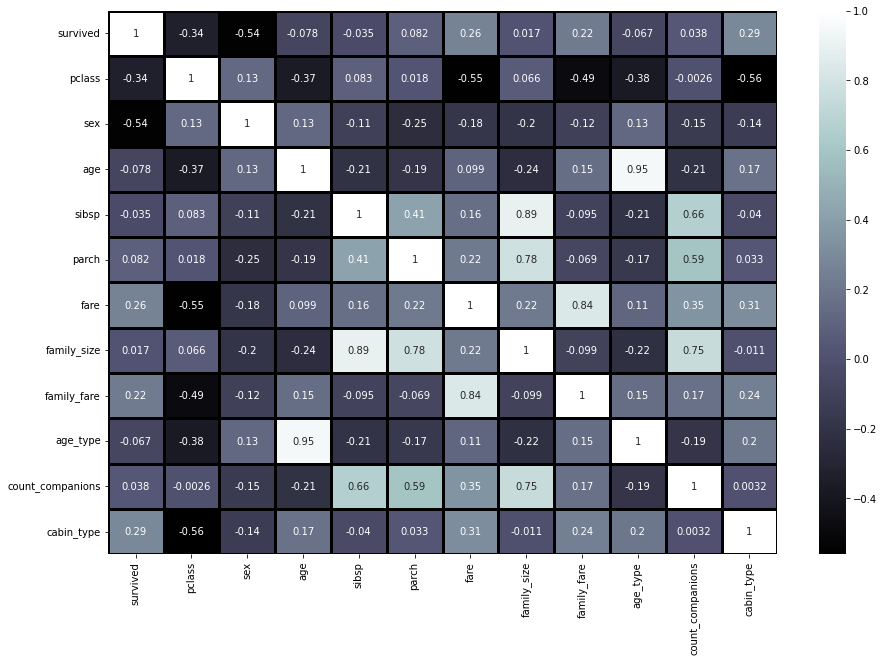

In [60]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True, linewidths=3, linecolor='black', cmap='bone');

Let's **start preparing the data for further model building**

----------------

#  <center>| Data Preprocessing |</center>

![](https://iprofi.kg/wp-content/uploads/2021/07/60ffd0153c1d3549690580.gif)

---------------

To begin with, we will **remove all unnecessary features that are of no importance**, we have already extracted everything necessary from them

And also split the train data into **X_train and y_train**

In [61]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,surname,family_size,family_fare,age_type,count_companions,cabin_type
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,N,S,Braund,2,3.62500,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,2,35.64165,2,0,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,N,S,Heikkinen,1,7.92500,1,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Futrelle,2,26.55000,2,1,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,N,S,Allen,1,8.05000,2,0,0


In [62]:
X_train = train.drop(['survived','name','ticket','cabin','surname', 'fare', 'sibsp','parch', 'age'], axis=1)
y_train = train['survived']

X_test = test.drop(['name','ticket','cabin', 'fare', 'sibsp','parch', 'age'], axis=1)

In [63]:
X_train.shape, X_test.shape

((891, 8), (418, 8))

### One Hot Encoding

Let's **separate all categorical features** using **one hot encoding**, for this we will use the **get_dummies ()** method built into **pandas**

But **before using get_dummies(), we need to make sure that all feature classes are present in both X_test data and X_train**

In [64]:
pd.get_dummies(X_train).columns.to_list() == pd.get_dummies(X_test).columns.to_list()

True

In [65]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [66]:
print('Train shape: ', X_train.shape)
print('\nTest shape: ', X_test.shape)
print('-'*30)
print('Train y: \n\n', y_train.value_counts(), sep='')

Train shape:  (891, 10)

Test shape:  (418, 10)
------------------------------
Train y: 

0    549
1    342
Name: survived, dtype: int64


Great, now we have 2 datasets that have the same number of columns.

Everything is ready to **start the model building process**

----------------

#  <center>| Machine Learning |</center>

![](https://4.bp.blogspot.com/-R1w3hy8_V6k/WuSOGXuhn1I/AAAAAAAATio/z4_6Pdwutk4qggn2W4dwAjFQC1Fj4gFrACLcBGAs/s640/1_FYFI4jbAUMqbXxlo6V_lBA.png) 

As I said in the introduction to the notebook, I will try **using gradient boosting from the sklearn library** and **gradient boosting from the xgboost library**.

I will compare their results, find out which of the implementations is better, and also talk a little about the differences in the implementations.


First, let's **import the necessary modules**.

In [67]:
random_state= 17

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import xgboost as xgb
xgb.set_config(verbosity=0)

In [69]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import confusion_matrix

----------------------------

I will **add some convenient functions for displaying plots and metrics** (I use these functions in almost all my other works, so I will not explain what they do once again)

In [70]:
def print_metrics(estimator, name):
    acc = cross_val_score(estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(estimator, X_train, y_train, cv=5, scoring='precision', n_jobs=-1)
    rec = cross_val_score(estimator, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    auc = cross_val_score(estimator, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    print(name,'\n--------------------------------')
    print('ACCURACY:', np.mean(acc))
    print('PRECISION:', np.mean(prec))
    print('RECALL:', np.mean(rec))
    print('AUC-ROC:', np.mean(auc))
    print('F1:', np.mean(f1))
    print('--------------------------------\n')

In [71]:
def plot_learning_curve(estimator, X, y):
    
    train_sizes, train_score, test_score = learning_curve(
    estimator =  estimator,
    X = X,
    y = y, 
    train_sizes = np.arange(0.1, 1.1 , 0.1), 
    cv = 5,
    n_jobs=-1,
    scoring='accuracy',
    random_state=random_state) 
    
    mean_train = np.mean(train_score, axis=1)
    mean_test = np.mean(test_score, axis=1)

    plt.figure(figsize=(15,7))
    plt.plot(train_sizes, mean_train, '--', color="b",  label="Training score", linewidth=4)
    plt.plot(train_sizes, mean_test ,color="g", label="Cross-validation score", linewidth=4)

    plt.title('Learning curve\n', fontsize=20)
    plt.xlabel("Size", fontsize=20),
    plt.ylabel("Score", fontsize=20),
    plt.legend(loc="best")
    plt.show()

In [72]:

def plot_validation_curve(estimator, X, y, param_name, param_range):
    train_score, test_score = validation_curve(
    estimator=estimator,
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    n_jobs=-1,
    scoring='accuracy')
    
    mean_train = np.mean(train_score, axis=1)
    mean_test = np.mean(test_score, axis=1)
    
    plt.figure(figsize=(15,7))
    plt.plot(param_range, mean_train, '--', color="r",  label="Training score", linewidth=4)
    plt.plot(param_range, mean_test ,color="g", label="Cross-validation score", linewidth=4)

    plt.title('Validation curve\n', fontsize=20)
    plt.xlabel(param_name, fontsize=20),
    plt.ylabel('Score', fontsize=20),
    plt.legend(loc="best")
    plt.show()

In [73]:
def plot_conf_matrix(y_true, y_pred):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.4g', cmap='RdGy', linewidths=3, linecolor='black')
    plt.title('\nConfusion Matrix for Train\n', fontsize=25);
    plt.xlabel('Predicted Values', fontsize=15)
    plt.ylabel('Actual Values', fontsize=15);

In [74]:
scores = [[], [], [], [], []]

def save_metrics(estimator):
    acc = np.mean(cross_val_score(estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
    prec = np.mean(cross_val_score(estimator, X_train, y_train, cv=5, scoring='precision', n_jobs=-1))
    rec = np.mean(cross_val_score(estimator, X_train, y_train, cv=5, scoring='recall', n_jobs=-1))
    f1 = np.mean(cross_val_score(estimator, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
    auc = np.mean(cross_val_score(estimator, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1))
    
    scores[0].append(acc)
    scores[1].append(prec)
    scores[2].append(rec)
    scores[3].append(f1)
    scores[4].append(auc)

---------------------

Now it is necessary to tell a little **general theory**:

1. **Boosting**


2. **Gradient boosting method**


3. **Difference in the implementation of gradient boosting in the sklearn and xgb**

### Boosting

Boosting is a greedy algorithm for constructing a composition of algorithms.

The main idea is that, having a **set of relatively weak learning algorithms, build a good linear combination of them.** It is similar to bagging in that the underlying learning algorithm is fixed.

The difference is that the **basic algorithms for composition are trained iteratively**, and each next algorithm tends to compensate for the shortcomings of the composition of all previous algorithms.

----------------

![](https://miro.medium.com/max/1200/1*FoOt85zXNCaNFzpEj7ucuA.png) 


------------------

### Gradient Boosting


The gradient boosting method is a generalization of other boosting methods, since it allows you to **optimize an arbitrary differentiable loss function.**

This **algorithm is similar to the gradient descent method used to solve optimization problems.**

The main idea is that each **next algorithm added to the composition is tuned to the remnants of previous algorithms.**

-------------------------

### Sklearn Gradient Boosting

1. How the basic algorithm is **used Decision tree**


2. Has **3 main types of regularization**:

  1) restriction on the tree structure: **maximum depth** (max_depth), **minimum number of objects to split a leaf** (min_samples_split)
 
  2) **controlling the learning rate** (learning_rate)
 
  3) **increasing the "dissimilarity" of trees due to randomization** (max_features)
 
  4) **using stochastic gradient descent** (subsample)


3. **Has 2 kinds of loss function**

--------------------------------

### Xgboost gradient boosting

1. As the basic algorithm **can use the Decision Tree, so can linear models**


2. **The optimization objective function is different from the usual implementation of gradient boosting, another regularizer is added to it** (I do not have very good English, so it will be difficult for me to explain what the regularizer consists of)


3. Has **5 main types of regularization**:
    
  1) restriction on the tree structure: **maximum depth** (max_depth), **minimum number of objects to divide the sheet** (min_child_weight)
 
 2) **controlling the learning rate** (learning_rate)
 
 3) **increasing the "dissimilarity" of trees due to randomization** (colsample_bytree)
 
 4) **using stochastic gradient descent** (subsample)
 
 5) **controlling the an additional regularizer** (gamma)
 
 6) **L1 and L2 regularization** ( reg_alpha, reg_lambda )
 
 P.S. **Items 5) and 6) refer specifically to the regularizer that is added to the optimization objective function**
 
 
4. It has **many types of loss functions designed for different types of tasks, including ranking tasks.** It is also possible to directly **set your custom loss function**
 
---------------------

It is believed that the implementation from the **xgb works much faster, but comparing the results, I did not find any serious differences**, perhaps the **speed difference will be more noticeable on large data samples**, but in this case it makes sense to use **LightGBM from Microsoft**

Ok, the theoretical part is over, let's **create 2 models from different libraries and compare the results out of the box**

## Base models

In [75]:
gb = GradientBoostingClassifier(random_state=random_state)
xgb = XGBClassifier(random_state=random_state, use_label_encoder=False, n_jobs=1, eval_metric='logloss')

In [76]:
%%time
name_est = ['Gradient Boost','XGB']
est = [gb, xgb]

for name, estim in zip(name_est, est):
    print()
    print_metrics(estim, name)


Gradient Boost 
--------------------------------
ACCURACY: 0.8282970309459543
PRECISION: 0.8092790542790542
RECALL: 0.7278772378516625
AUC-ROC: 0.8856131725997866
F1: 0.7632933929342786
--------------------------------


XGB 
--------------------------------
ACCURACY: 0.8305316678174629
PRECISION: 0.804145369529002
RECALL: 0.7395566922421142
AUC-ROC: 0.8708090323920118
F1: 0.7691304882494973
--------------------------------

CPU times: user 249 ms, sys: 63.7 ms, total: 313 ms
Wall time: 7.54 s


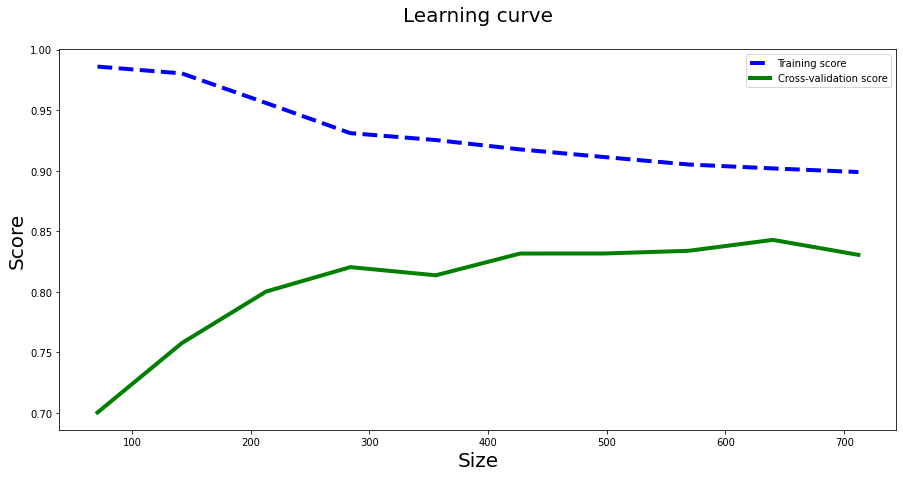

In [77]:
plot_learning_curve(gb, X_train, y_train)

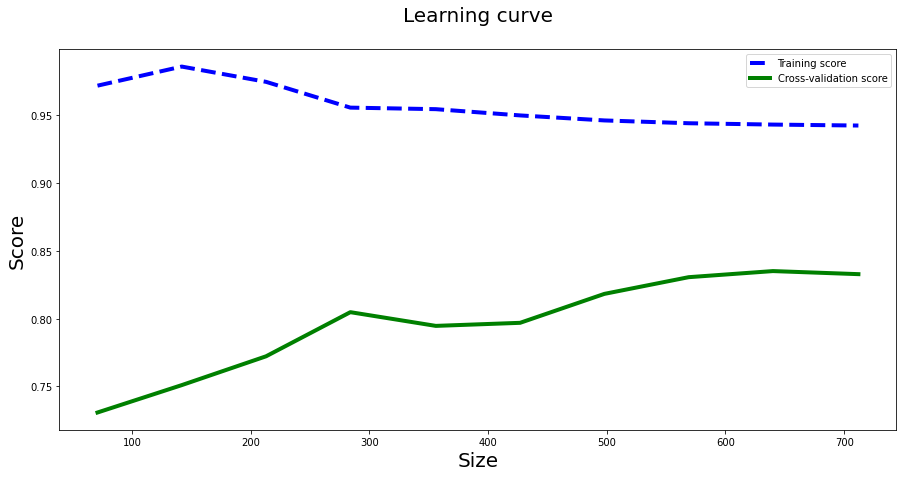

In [78]:
plot_learning_curve(xgb, X_train, y_train)

As we can see, **xgb and gb showed roughly the same metrics results** by calling them out of the box

But **boosted models are very sensitive to hyperparameter tuning**, so let's get familiar with the hyperparameter tuning of these models.

## Tuning The Hyper-Parameters 

In this notebook, I **will not use the validation curve**, but I would **like to show how convenient it is to check individual features using this curve**, it is somewhat similar to a learning curve, but instead of data size, it compares different values of indicators.

In the next works, I will try to use it more often, because I only recently learned about it :)

I also think this is **not a very convenient setting for gradient boosting**, **since most hyperparameters are very sensitive to each other**. An increase in one may have a bad effect on the other, so we **will use a faster and more banal hyperparameter optimization, like RandomizedSearchCV**

In this notebook, I set myself the task of **explaining what gradient boosting is and how it should be configured.**

In [79]:
max_depth_range = range(1, 10, 1)

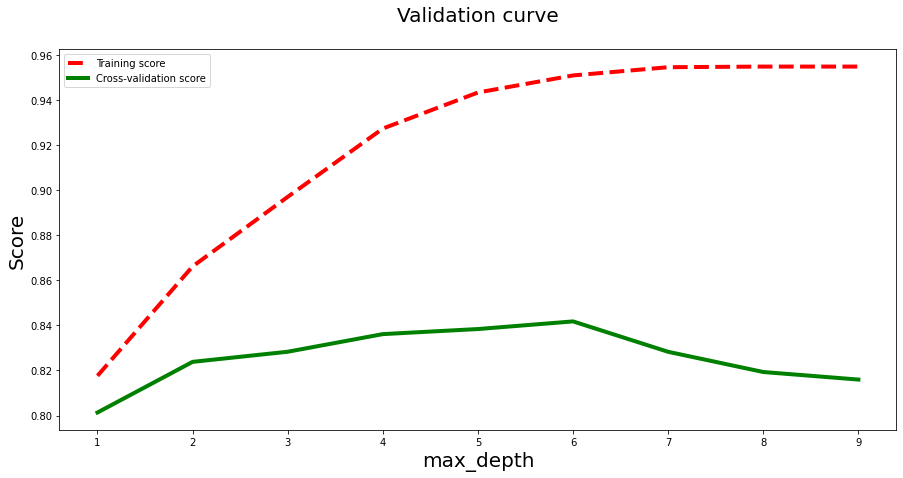

In [80]:
plot_validation_curve(gb, X_train, y_train, 'max_depth', max_depth_range)

**It is clearly seen that by adjusting max_depth, the best performance can be achieved at a depth of 6**

--------------------

So, let's **take a closer look at hyperparameters in two implementations of gradient boosting, starting with the xgb.** (I will not use all possible hyperparameters, but in my opinion the most basic ones, for example, I will not change the loss function)

###  XGB Hyper-Parameters

1. **learning_rate**

2. **n_estimators**

There is a **linear relationship between learing_rate and n_estimators**. The **lower the learing_rate** value, the **more n_estimators** we need.

It is advisable to **set lower values of the learing_rate, so we guarantee ourselves that we will not get stuck in the local minimum of the function**


3. **max_depth**

4. **min_child_weight**

**max_depth** and **min_child_weight** are **classic settings for a single decision tree.**

**max_depth adds more regularization and prevents model overfitting.** Therefore, first of all, I think it is necessary to adjust this parameter, and then min_child_weight




5. **subsample**

6. **colsample_bytree**

**subsample** and **colsample_bytree** parameters responsible for the **differences between the trees and the data** that comes into model.

**subsample** makes it possible to give only a **certain batch from the total data sample.**

**colsample_bytree** makes it possible to give only a **certain number of features to the input of the decision tree.**

Both of these parameters are **very important**.


7. **gamma**

8. **reg_alpha**

9. **reg_lambda**

As for these parameters, they are **all responsible for the regularizer in the main optimization function of the model.**

It is difficult for me to single out one more important.

**alpha** and **lambda** are parameters from **l1** and **l2** regularizations in standard algorithms.

**gamma** is the parameter **responsible for the strength of the regularizer**, which consists of alpha and lambda

--------------------

P.S. Sorry if there are any inaccuracies in the explanations, I myself am still learning and I try to give explanations as I myself understand this topic :)

In [81]:
xbs_param = {'learning_rate':[.005, .05, .01, .1, 1],
            'n_estimators': range(50, 501, 50),
            'max_depth':range(2, 10, 1),
            'gamma':np.arange(0, 1.1, 0.1),
            'min_child_weight':range(2, 21, 1),
            'reg_alpha':np.arange(0, 1.1, 0.1),
            'reg_lambda':np.arange(0, 1.1, 0.1),
            'subsample':np.arange(0.2, 1.1, 0.1),
            'colsample_bytree':np.arange(0.2, 1.1, 0.1)}

**Sklearn Gradient boosting has a smaller number of configurable parameters**, but all of them are also present in the xgb implementation.

###  GradientBoostingClassifier Hyper-Parameters

1. **loss**

loss can take 2 values: **'deviance'** and **'exponential'**.

For **deviance**, we use the classic **logistic regression loss function**.

With **exponential**, we only **use the exponential** ( e^-k ), which cannot be differentiable, so **gradient boosting becomes an implementation of ADABoosting** (sklearn has a separate ADABoostingClassifier)



2. **learning_rate**

3. **n_estimators**

**learning_rate** and **n_estimators** are similar to xgb implementation.

The **lower the learing_rate** value, the **more n_estimators** we need.



4. **max_depth**

5. **min_samples_split**

**max_depth** and **min_samples_split** are the same implementation in xgb. **min_samples_split** is the **same as min_child_weight.**

6. **max_features**

7. **subsample**

**subsample** and **max_features** parameters are similar to xgb implementation. **max_features** is the **same as colsample_bytree.**

However, **max_features** has 2 more values **'sqrt', 'log2'** besides float values.

**max_features=sqrt(n_features) and max_features=log2(n_features)**

It is believed that the **most optimal number of features is sqrt(n_features)**

In [82]:
gb_param = {'loss':['deviance', 'exponential'],
            'learning_rate':[.005, .05, .01, .1, 1],
            'n_estimators': range(50, 501, 50),
            'max_depth':range(2, 10, 1),
            'min_samples_split':range(2, 21, 1),
            'max_features':['sqrt','log2', None],
            'subsample':np.arange(0.2, 1, 0.1),}

Great, after creating dict of all hyperparameters, let's find the best ones with **RandomizedSearchCV.**


I will **not use GridSearchCV** further, as **it is too long** and the purpose of this notebook is not to find ideal hyperparameters for solving the problem. The main task is to show which hyperparameters need to be tuned and how they will affect the result

In [83]:
from sklearn.model_selection import RandomizedSearchCV

In [84]:
rs_xgb = RandomizedSearchCV(xgb, xbs_param, cv=5, n_jobs=-1, random_state=random_state, scoring='accuracy', n_iter=100)
rs_gb = RandomizedSearchCV(gb, gb_param, cv=5, n_jobs=-1, random_state=random_state, scoring='accuracy', n_iter=100)

In [85]:
%%time
rs_xgb.fit(X_train, y_train)
rs_gb.fit(X_train, y_train)
print('-'*100)

----------------------------------------------------------------------------------------------------
CPU times: user 5.88 s, sys: 185 ms, total: 6.06 s
Wall time: 3min 34s


Let's **collect all the results that RandomizedSearchCV found in 100 iterations and display the best of them**

To do this, use the **cv_results_** method

In [86]:
param_xgb = pd.DataFrame(rs_xgb.cv_results_)\
.sort_values('mean_test_score')\
.reset_index(drop=True)\
.sort_values('mean_test_score', ascending=False)

param_xgb.drop(['mean_fit_time', 
                'std_fit_time', 
                'mean_score_time',
                'std_score_time', 
                'params', 
                'split0_test_score', 
                'split1_test_score', 
                'split2_test_score',
                'split3_test_score',
                'split4_test_score',
                'rank_test_score'],
            axis=1, inplace=True)

param_xgb.columns = param_xgb.columns.map(lambda x: x.replace('param_',''))
param_xgb.rename(columns={'mean_test_score': 'mean_score', 'std_test_score':'std_score'}, inplace=True)



param_gb = pd.DataFrame(rs_gb.cv_results_)\
.sort_values('mean_test_score')\
.reset_index(drop=True)\
.sort_values('mean_test_score', ascending=False)

param_gb.drop(['mean_fit_time', 
               'std_fit_time', 
               'mean_score_time',
               'std_score_time', 
               'params', 
               'split0_test_score', 
               'split1_test_score', 
               'split2_test_score',
               'split3_test_score',
               'split4_test_score',
               'rank_test_score'],
            axis=1, inplace=True)


param_gb.columns = param_gb.columns.map(lambda x: x.replace('param_',''))
param_gb.rename(columns={'mean_test_score': 'mean_score', 'std_test_score':'std_score'}, inplace=True)

In [87]:
param_xgb.head(5)

,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,mean_score,std_score
99,1.0,1.0,0.6,50,4,5,0.1,0.8,0.8,0.832798,0.020292
98,0.6,0.5,0.1,400,3,3,0.1,0.1,1.0,0.832785,0.020724
97,0.5,0.9,0.0,300,3,5,0.05,0.2,0.5,0.831649,0.017044
96,0.7,0.3,0.4,100,3,2,0.1,0.3,1.0,0.831649,0.017411
95,1.0,0.6,0.2,400,9,5,0.1,0.1,0.8,0.831649,0.012816


In [88]:
param_gb.head(5)

,subsample,n_estimators,min_samples_split,max_features,max_depth,loss,learning_rate,mean_score,std_score
99,0.7,250,10,log2,5,exponential,0.05,0.842872,0.021616
98,0.4,400,3,log2,6,deviance,0.01,0.840631,0.028093
97,0.8,250,8,None,4,exponential,0.05,0.840619,0.023787
96,0.2,100,7,None,7,exponential,0.1,0.840606,0.021045
95,0.8,400,9,log2,3,exponential,0.05,0.839508,0.015301


Now, **looking at mean_score and std_score**, we can understand what results can be expected from the selected combination of parameters.

You **could also fine-tune the hyperparameter ranges this way to use GridSearchCV**, but this time I won't do that.

In [89]:
best_xgb = rs_xgb.best_estimator_
best_gb = rs_gb.best_estimator_

In [90]:
name_est.append('Tuned Gradient Boost')
name_est.append('Tuned XGB')
est.append(best_gb)
est.append(best_xgb)

for name, estim in zip(name_est[2:], est[2:]):
    print()
    print_metrics(estim, name)


Tuned Gradient Boost 
--------------------------------
ACCURACY: 0.8428723871696693
PRECISION: 0.8391936866636215
RECALL: 0.7337169650468883
AUC-ROC: 0.8830874904989738
F1: 0.7808566141550384
--------------------------------


Tuned XGB 
--------------------------------
ACCURACY: 0.8327976900382901
PRECISION: 0.8293252930168695
RECALL: 0.7132992327365729
AUC-ROC: 0.8763286949838136
F1: 0.7647537741072664
--------------------------------



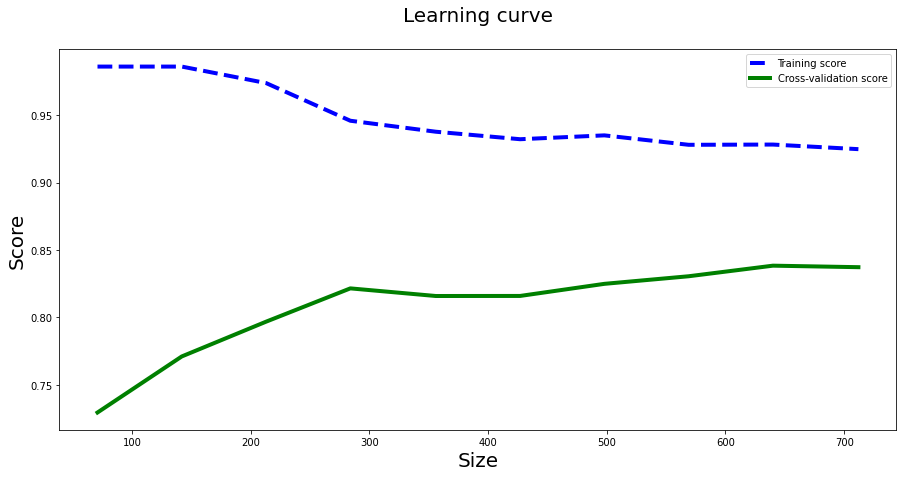

In [91]:
plot_learning_curve(best_gb, X_train, y_train)

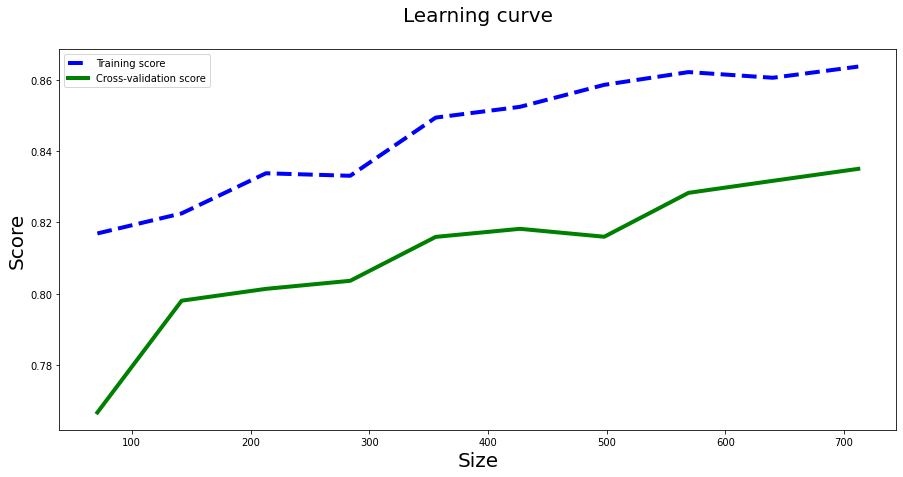

In [92]:
plot_learning_curve(best_xgb, X_train, y_train)

Great, we **see that the metric results are noticeably higher for gb, but worse for xgb**

On the **learning_curve** **for best_gb**, we observe a **high variane problem** when the **train score is much higher than the cross-val score**

The **learning_curve** **for best_xgb** has good results, **no problems with high variance, and no problems with high bias.**

## Results Analysis

In [93]:
for estim in est:
    save_metrics(estim)

final_result = {'Accuracy':scores[0],
               'Precision':scores[1],
               'Recall':scores[2],
               'F1':scores[3],
               'ROC-AUC':scores[4]}

In [94]:
result_df = pd.DataFrame(final_result, index=name_est)

In [95]:
result_df.T

,Gradient Boost,XGB,Tuned Gradient Boost,Tuned XGB
Accuracy,0.828297,0.830532,0.842872,0.832798
Precision,0.809279,0.804145,0.839194,0.829325
Recall,0.727877,0.739557,0.733717,0.713299
F1,0.763293,0.769130,0.780857,0.764754
ROC-AUC,0.885613,0.870809,0.883087,0.876329


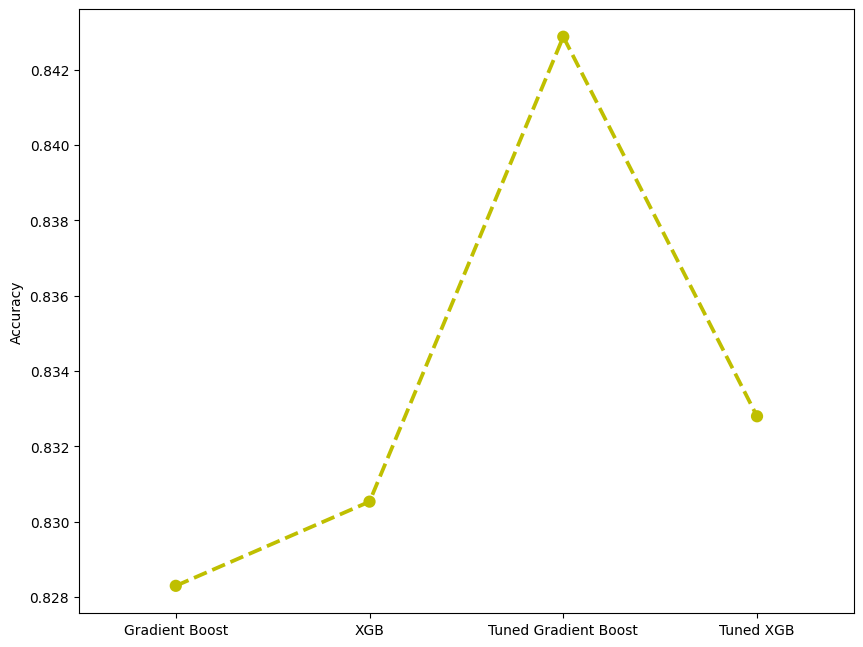

In [96]:
plt.figure(figsize=(10,8), dpi=100)
sns.pointplot(y=result_df['Accuracy'] , x=result_df.index ,markers='o',linestyles='--', color='y');

Drawing conclusions based on **obtained metrics and learning curve**, in this competition **gradient boosting from sklearn performed better than gradient boosting from xgb**

**xg**b showed the best results **out of the box**

Also, **let's plot the features that our best model considers important**

Let's do this with the **feature_importances_** method.

In [97]:
feature_importance = pd.DataFrame(best_gb.feature_importances_, index=X_train.columns, columns=['importance'])\
.sort_values(['importance'], ascending=False)

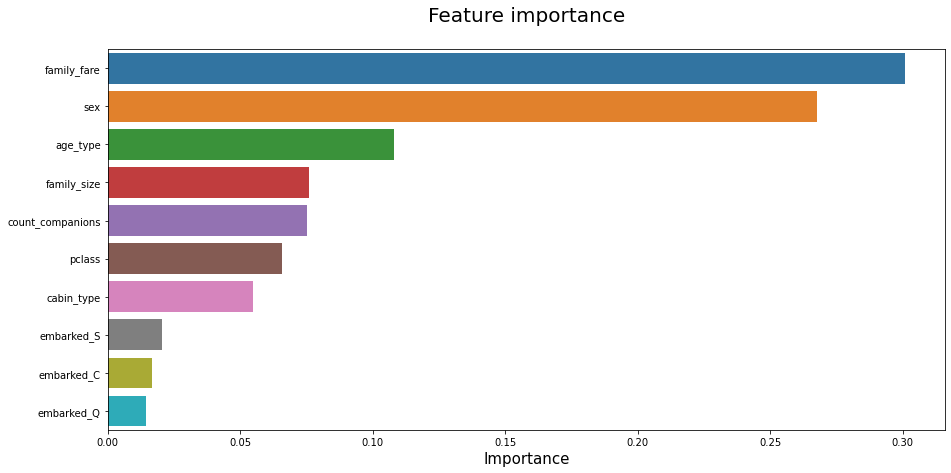

In [98]:
plt.figure(figsize=(15,7))
sns.barplot(data=feature_importance, y=feature_importance.index, x='importance')
plt.title('Feature importance\n', fontsize=20)
plt.xlabel('Importance', fontsize=15);

**family_fare** and **Sex** turned out to be the **most important features**. It can be assumed that **fare** would also be a more important feature than the others.

--------------------

Let's also take a **look at the confusion matrix for y_train**

In [99]:
best_gb.fit(X_train, y_train)
predict_train = best_gb.predict(X_train)

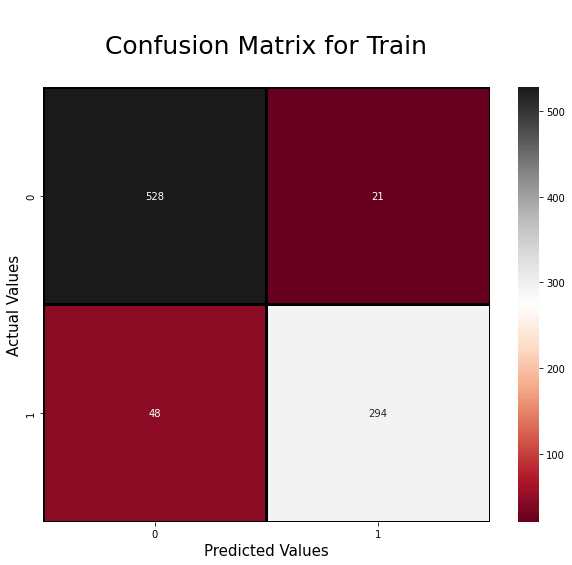

In [100]:
plot_conf_matrix(y_train, predict_train)

#  <center>| Final result & Submission |</center>

Great, let's **make a final predictio**n on the test data and **send it to Kaggle**

In [101]:
final_predict = best_gb.predict(X_test)

In [102]:
output_example.T

,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
PassengerId,892,893,894,895,896,897,898,899,900,901,...,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309
Survived,0,1,0,0,1,0,1,0,1,0,...,1,1,1,1,1,0,1,0,0,0


In [103]:
submission = pd.DataFrame({'PassengerId':output_example['PassengerId'], 'Survived': final_predict})

In [104]:
submission.to_csv('submission_titanic.csv', index=False)

## <center>Thank you for watching my project, I will be grateful if you upvoted and give feedback about my work in the comments. I want to improve my skills, and if you find any mistakes in the project, please tell me about it. Also, if you liked the structure of the project, you can see the rest of my project, in each of them I try to describe my actions in detail, as well as not just solve the problem, but use new technologies </center>

![](https://data.whicdn.com/images/218833361/original.gif)